In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import acnportal
import sklearn
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns
import sys

from copy import deepcopy
import warnings
import pytz
import time
import numpy as np
import pandas as pd
import pickle
from datetime import datetime, timedelta
from enum import Enum
from collections import namedtuple, defaultdict
import gzip
import random
import os
import json

from acnportal import acnsim
from acnportal import algorithms
from acnportal.acnsim.events import EventQueue
# from acnportal.signals.tariffs.tou_tariff import TimeOfUseTariff
from utility_functions.signals.tariffs.tou_tariff import TimeOfUseTariff
from acnportal.acnsim.events import GaussianMixtureEvents
from acnportal.contrib.acnsim import StochasticNetwork
from acnportal.acnsim.network import ChargingNetwork
from modified_adacharge import modified_adacharge
from modified_simulator import modified_simulator
# from acnportal.acnsim import analysis
from utility_functions import analysis
# from modified_evse import *
from acnportal.acnsim.models.evse import get_evse_by_type
# import sqlite3
# from sqlalchemy import create_engine

from modified_adacharge.modified_interface import Interface, SessionInfo, InfrastructureInfo
from modified_adacharge.modified_adaptive_charging_optimization_with_priority import (
    AdaptiveChargingOptimizationWithPriority,
    ObjectiveComponent,
    InfeasibilityException
)
from modified_adacharge.acn_scenario_generator_with_priority import (
    ACNScenarioGenerator,
    SCENARIOS,
    PriorityConfig,
    generate_scenario_with_priorities,
    list_scenarios
)

In [3]:
# This method won't take a evse_per_phase argument
def ev_fleet_level_2_network(transformer_cap=130):
    """ Configurable charging network for level-2 EVSEs connected line to line
        at 415 V.

    Args:
        transformer_cap (float): Capacity of the transformer feeding the network
          [kW]
        evse_per_phase (int): Number of EVSEs on each phase. Total number of
          EVSEs will be 3 * evse_per_phase.

    Returns:
        ChargingNetwork: Configured ChargingNetwork.
    """
    network = StochasticNetwork(early_departure=True)
    # network = ChargingNetwork()
    voltage = 415
    evse_type = 'AeroVironment'
    # evse_type = 'ClipperCreek'

    # Define the sets of EVSEs in the Caltech ACN.
    AB_ids = ['AB-{0}'.format(i) for i in range(5)]
    BC_ids = ['BC-{0}'.format(i) for i in range(5)]
    CA_ids = ['CA-{0}'.format(i) for i in range(5)]

    # print(AB_ids)

    # Add Caltech EVSEs
    for evse_id in AB_ids:
        network.register_evse(get_evse_by_type(evse_id, evse_type), voltage, 30)
    for evse_id in BC_ids:
        network.register_evse(get_evse_by_type(evse_id, evse_type), voltage, -90)
    for evse_id in CA_ids:
        network.register_evse(get_evse_by_type(evse_id, evse_type), voltage, 150)

    # Add Caltech Constraint Set
    AB = acnsim.Current(AB_ids)
    BC = acnsim.Current(BC_ids)
    CA = acnsim.Current(CA_ids)

    # Define intermediate currents
    I3a = AB - CA
    I3b = BC - AB
    I3c = CA - BC
    I2a = (1 / 4) * (I3a - I3c)
    I2b = (1 / 4) * (I3b - I3a)
    I2c = (1 / 4) * (I3c - I3b)

    # Build constraint set
    primary_side_constr = transformer_cap * 1000 / 3 / 415
    print(primary_side_constr)
    secondary_side_constr = transformer_cap * 1000 / 3 / 230
    print(secondary_side_constr)
    network.add_constraint(I3a, secondary_side_constr, name='Secondary A')
    network.add_constraint(I3b, secondary_side_constr, name='Secondary B')
    network.add_constraint(I3c, secondary_side_constr, name='Secondary C')
    network.add_constraint(I2a, primary_side_constr, name='Primary A')
    network.add_constraint(I2b, primary_side_constr, name='Primary B')
    network.add_constraint(I2c, primary_side_constr, name='Primary C')

    return network

In [4]:
# How long each time discrete time interval in the simulation should be.
PERIOD = 5  # minutes

# Voltage of the network.
VOLTAGE = 415  # volts      

DEFAULT_BATTERY_POWER = 21 # kW
MAX_POWER_KW = 21  # kW (Default maximum charging rate for each EV battery.)
NUM_EVSES = 15
NUM_SESSIONS = 45

# Priority configuration
PRIORITY_CONFIG = PriorityConfig(
    max_priority_pct=0.27,  # Maximum 27% priority vehicles
    min_energy_kwh=10,
    max_energy_kwh=25,
    min_duration_hours=2.0,
    high_energy_threshold=25,
    high_energy_min_duration=3.0
)

# Timezone
TIMEZONE = pytz.timezone('Australia/Melbourne')

print(f"Configuration:")
print(f"  - Period: {PERIOD} min")
print(f"  - Voltage: {VOLTAGE} V")
print(f"  - Max Power: {MAX_POWER_KW} kW")
print(f"  - EVSEs: {NUM_EVSES}")
print(f"  - Sessions: {NUM_SESSIONS}")
print(f"  - Max priority %: {PRIORITY_CONFIG.max_priority_pct*100:.0f}%")

Configuration:
  - Period: 5 min
  - Voltage: 415 V
  - Max Power: 21 kW
  - EVSEs: 15
  - Sessions: 45
  - Max priority %: 27%


#### Generate synthetic events for simulation

In [5]:
# Generate scenario S1_baseline
# Available scenarios: S1_baseline, S2_low_priority, S3_high_priority, 
#                      S4_morning_rush, S5_cloudy_day, S6_peak_stress
scenario_name = 'S6_peak_stress'

events, priority_ids, session_params = generate_scenario_with_priorities(
    scenario_key=scenario_name,
    n_sessions=NUM_SESSIONS,
    period=PERIOD,
    voltage=415,  # Match your network voltage
    max_battery_power=MAX_POWER_KW,
    #seed=42,
    priority_config=PRIORITY_CONFIG
)

print(f"\nScenario {scenario_name} Generated:")
print(f"  - Total sessions: {len(session_params)}")
print(f"  - Priority EVs: {len(priority_ids)} ({len(priority_ids)/len(session_params)*100:.1f}%)")
print(f"  - Priority session IDs: {sorted(list(priority_ids))}")


Scenario S6_peak_stress Generated:
  - Total sessions: 45
  - Priority EVs: 22 (48.9%)
  - Priority session IDs: ['session_1', 'session_10', 'session_12', 'session_13', 'session_14', 'session_18', 'session_19', 'session_20', 'session_21', 'session_22', 'session_23', 'session_24', 'session_26', 'session_27', 'session_28', 'session_30', 'session_31', 'session_32', 'session_5', 'session_7', 'session_8', 'session_9']


In [6]:
# Checking session details
from copy import deepcopy

session_copy = deepcopy(events)
# print(type(session_copy))
session_list = list(session_copy.queue)
for session in session_list:
    print(session[0], session[1].ev._session_id, session[1].ev.arrival, \
          session[1].ev.departure, session[1].ev.requested_energy, session[1].event_type)

87 session_34 87 174 37.03 Plugin
91 session_42 91 168 31.99 Plugin
104 session_28 104 157 20.15 Plugin
96 session_2 96 126 25.71 Plugin
95 session_4 95 144 32.89 Plugin
166 session_23 166 191 16.61 Plugin
108 session_12 108 142 13.37 Plugin
174 session_8 174 258 8.39 Plugin
148 session_37 148 182 8.3 Plugin
96 session_3 96 186 35.8 Plugin
101 session_43 101 146 33.08 Plugin
171 session_6 171 227 25.59 Plugin
185 session_26 185 236 19.6 Plugin
173 session_27 173 200 10.72 Plugin
120 session_30 120 186 9.19 Plugin
178 session_32 178 232 20.18 Plugin
178 session_31 178 214 20.78 Plugin
203 session_36 203 265 37.93 Plugin
183 session_18 183 224 11.52 Plugin
169 session_39 169 213 30.32 Plugin
165 session_19 165 200 23.31 Plugin
136 session_44 136 183 34.3 Plugin
212 session_22 212 287 21.81 Plugin
203 session_5 203 251 7.74 Plugin
211 session_24 211 281 15.72 Plugin
192 session_25 192 243 39.66 Plugin
187 session_11 187 215 36.84 Plugin
183 session_1 183 258 7.76 Plugin
175 session_13 175

#### Run Simulation with New Equation

In [7]:
sch = {}
sch['Unctrl'] = algorithms.UncontrolledCharging()
sch['LLF'] = algorithms.SortedSchedulingAlgo(algorithms.least_laxity_first)
sch['RR'] = algorithms.RoundRobin(algorithms.first_come_first_served, continuous_inc=1)

cost_min_obj = [
                modified_adacharge.ObjectiveComponent(modified_adacharge.tou_energy_cost_with_pv),
                modified_adacharge.ObjectiveComponent(modified_adacharge.non_completion_penalty),
                # modified_adacharge.ObjectiveComponent(modified_adacharge.non_completion_penalty_for_priority_ev, 2),
                # modified_adacharge.ObjectiveComponent(modified_adacharge.non_completion_penalty_without_priority_ev),
                modified_adacharge.ObjectiveComponent(modified_adacharge.quick_charge, 1e-6)
               ]
#  need to resolve the issue here. It's not calling intended scheduler. The scheduler should be AdaptiveChargingOptimizationWithPriority
sch['MPC'] = modified_adacharge.AdaptiveSchedulingAlgorithm(cost_min_obj, solver="MOSEK", quantize=True, reallocate=False, peak_limit=1000, max_recompute=1)

In [10]:
sims = dict()
def run_experiment(alg_name, cap):
    """ Run simulation for the events defined previously and the specified
        network / algorithm / events.
    """
    # Timezone of the ACN we are using.
    # timezone = pytz.timezone('America/Los_Angeles')
    # Australian timezone for the experiment
    timezone = pytz.timezone('Australia/Melbourne')

    start = timezone.localize(datetime(2026, 1, 14))
    end = timezone.localize(datetime(2026, 1, 14))

    cn = ev_fleet_level_2_network(transformer_cap=cap)

    alg = deepcopy(sch[alg_name])
    alg.max_rate_estimator = algorithms.SimpleRampdown()
    alg.estimate_max_rate = True
    experiment_events = deepcopy(events)
    signals = {'tariff': TimeOfUseTariff('sce_tou_ev_4_march_2019')}

    sim = modified_simulator.Simulator(cn, alg, experiment_events, start, period=PERIOD, signals=signals, verbose=False)
    print("Running...")
    start_simulation = time.time()
    if alg_name == "MPC_Offline":
        alg.register_events(experiment_events)
        alg.solve()
    # if alg_name == "MPC":
    #     sim.high_priority_ev_sessions = ["session_19", "session_7", "session_15", "session_10"]
    # sim.high_priority_ev_sessions = ["session_4", "session_12", "session_2"]
    sim.run()
    print(f"Run time: {time.time() - start_simulation}")

    return sim

In [11]:
warnings.simplefilter("ignore")

capacities = list(range(130, 160, 10))
alg_names = ["Unctrl", "RR", "LLF", "MPC"]

for cap in capacities:
    for alg_name in alg_names:
        config = (alg_name, cap)
        print(config)
        try:
            sims[config] = run_experiment(*config)
        except Exception as e:
            print(f"InfeasibilityException: {e}")
            sims[config] = None
            continue

('Unctrl', 130)
104.41767068273093
188.40579710144928
Running...
Run time: 0.21633219718933105
('RR', 130)
104.41767068273093
188.40579710144928
Running...
Run time: 3.033363103866577
('LLF', 130)
104.41767068273093
188.40579710144928
Running...
Run time: 0.6670060157775879
('MPC', 130)
104.41767068273093
188.40579710144928
Running...
Run time: 12.764479160308838
('Unctrl', 140)
112.44979919678714
202.89855072463766
Running...
Run time: 0.20252728462219238
('RR', 140)
112.44979919678714
202.89855072463766
Running...
Run time: 3.015406847000122
('LLF', 140)
112.44979919678714
202.89855072463766
Running...
Run time: 0.7351551055908203
('MPC', 140)
112.44979919678714
202.89855072463766
Running...
Run time: 16.753804922103882
('Unctrl', 150)
120.48192771084338
217.3913043478261
Running...
Run time: 0.24504804611206055
('RR', 150)
120.48192771084338
217.3913043478261
Running...
Run time: 3.2302582263946533
('LLF', 150)
120.48192771084338
217.3913043478261
Running...
Run time: 0.664581060409

In [ ]:
# result_dir = "results/sims/new_simulation"
# if not os.path.exists(result_dir):
#     os.makedirs(result_dir)
    
# for config, sim in sims.items():
#     name = "results/sims/new_simulation/{0}-{1}.json.gz".format(*config)
#     if not os.path.exists(name):
#         data = sim.to_json()
#         with gzip.GzipFile(name, 'w') as fout:
#             fout.write(json.dumps(data).encode('utf-8'))

#### Result Analysis

In [12]:
def calc_metrics(config, sim):
    metrics = {
        "Network Type": "three_phase",
        "Algorithm": config[0],
        "Capacity (kW)": config[1],
        "Energy Delivered (%)": analysis.proportion_of_energy_delivered(sim) * 100,
        "Demand met": analysis.proportion_of_demands_met(sim) * 100,
        "Max Utilization (%)": np.max(analysis.aggregate_power(sim)) / config[1] * 100,
        "energy_cost": analysis.energy_cost(sim),
        "total_energy_delivered": analysis.total_energy_delivered(sim),
        "Energy Delivered to priority evs (%)": analysis.proportion_of_priority_evs_energy_delivered(sim, priority_ids),
        "Peak (kW)": np.max(analysis.aggregate_power(sim))
    }
    metrics["Current Unbalance"] = np.nanmean(analysis.current_unbalance(sim, ['Secondary {0}'.format(p) for p in 'ABC'], 'NEMA'))

    return metrics

In [13]:
# filter the sims dict to only include the ones that are not None
sims = {k: v for k, v in sims.items() if v is not None}

In [14]:
metrics = pd.DataFrame(calc_metrics(config, sim) for config, sim in sims.items()).round(3)
metrics.rename(columns={"Capacity (kW)": "capacity"}, inplace=True)

In [15]:
metrics

,Network Type,Algorithm,capacity,Energy Delivered (%),Demand met,Max Utilization (%),energy_cost,total_energy_delivered,Energy Delivered to priority evs (%),Peak (kW),Current Unbalance
0,three_phase,Unctrl,130,101.780,97.778,143.015,88.528,1094.493,103.835,185.920,0.290
1,three_phase,RR,130,92.180,86.667,99.919,78.993,991.262,99.743,129.895,0.269
2,three_phase,LLF,130,92.087,86.667,99.919,78.882,990.259,99.763,129.895,0.289
3,three_phase,MPC,130,90.672,77.778,79.169,76.813,975.042,98.389,102.920,0.310
4,three_phase,Unctrl,140,101.677,97.778,132.800,88.432,1093.387,103.835,185.920,0.281
5,three_phase,RR,140,92.074,86.667,97.821,78.870,990.121,99.722,136.950,0.255
6,three_phase,LLF,140,92.078,86.667,97.525,78.873,990.155,99.732,136.535,0.251
7,three_phase,MPC,140,93.592,84.444,85.371,79.165,1006.444,100.053,119.520,0.244
8,three_phase,Unctrl,150,101.677,97.778,132.800,88.458,1093.387,103.835,199.200,0.304
9,three_phase,RR,150,92.299,86.667,96.003,79.105,992.542,99.753,144.005,0.297


In [16]:
def calculate_metrics(sim, priority_ids: set) -> dict:
    """
    Calculate performance metrics from simulation results.
    
    Args:
        sim: Simulator object
        priority_ids: Set of priority session IDs
        
    Returns:
        Dictionary of metrics
    """
    if sim is None:
        return None
    
    # Overall energy delivery
    total_energy_delivered = analysis.total_energy_delivered(sim)
    total_energy_requested = analysis.total_energy_requested(sim)
    overall_fulfillment = (total_energy_delivered / total_energy_requested * 100 
                          if total_energy_requested > 0 else 0)
    
    # Per-session analysis
    priority_delivered = 0
    priority_requested = 0
    non_priority_delivered = 0
    non_priority_requested = 0
    
    for ev in sim.ev_history.values():
        delivered = ev.energy_delivered
        requested = ev.requested_energy
        session_id = ev._session_id  # Get session_id from the EV object
        
        if session_id in priority_ids:
            priority_delivered += delivered
            priority_requested += requested
        else:
            non_priority_delivered += delivered
            non_priority_requested += requested
    
    priority_fulfillment = (priority_delivered / priority_requested * 100 
                           if priority_requested > 0 else 0)
    non_priority_fulfillment = (non_priority_delivered / non_priority_requested * 100
                               if non_priority_requested > 0 else 0)
    
    # Peak demand
    peak = sim.peak
    
    return {
        'overall_fulfillment': overall_fulfillment,
        'priority_fulfillment': priority_fulfillment,
        'non_priority_fulfillment': non_priority_fulfillment,
        'total_energy_delivered': total_energy_delivered,
        'peak_demand_A': peak
    }

# Calculate metrics for all algorithms
results = {
    'AQPC': sims.get(('MPC', 150)),
    'Round Robin': sims.get(('RR', 150)),
    'LLF': sims.get(('LLF', 150))
}

metrics = {}
for name, sim in results.items():
    if sim is not None:
        metrics[name] = calculate_metrics(sim, priority_ids)

# Display results table
if metrics:
    metrics_df = pd.DataFrame(metrics).T
    print("\n" + "="*70)
    print("SIMULATION RESULTS COMPARISON")
    print("="*70)
    print(metrics_df.round(2).to_string())
else:
    print("No simulation results available.")


SIMULATION RESULTS COMPARISON
             overall_fulfillment  priority_fulfillment  non_priority_fulfillment  total_energy_delivered  peak_demand_A
AQPC                       93.59                100.05                     90.67                 1006.44          288.0
Round Robin                92.30                 99.75                     88.93                  992.54          347.0
LLF                        92.10                 99.79                     88.62                  990.36          347.0


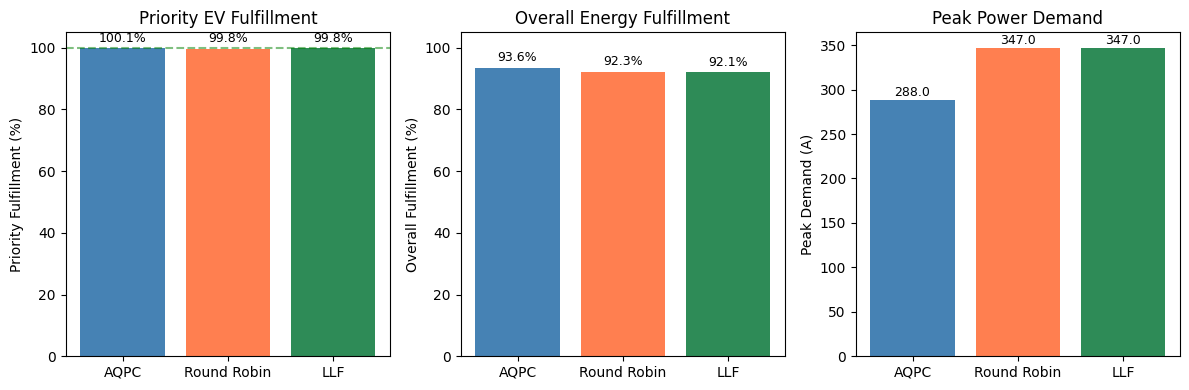


Figure saved as 'integration_test_results.png'


In [17]:
# Create comparison visualization
if metrics:
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    alg_names = list(metrics.keys())
    colors = ['steelblue', 'coral', 'seagreen']
    
    # 1. Priority Fulfillment
    ax = axes[0]
    values = [metrics[alg]['priority_fulfillment'] for alg in alg_names]
    bars = ax.bar(alg_names, values, color=colors[:len(alg_names)])
    ax.set_ylabel('Priority Fulfillment (%)')
    ax.set_title('Priority EV Fulfillment')
    ax.set_ylim(0, 105)
    ax.axhline(y=100, color='green', linestyle='--', alpha=0.5, label='Target')
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{val:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # 2. Overall Fulfillment
    ax = axes[1]
    values = [metrics[alg]['overall_fulfillment'] for alg in alg_names]
    bars = ax.bar(alg_names, values, color=colors[:len(alg_names)])
    ax.set_ylabel('Overall Fulfillment (%)')
    ax.set_title('Overall Energy Fulfillment')
    ax.set_ylim(0, 105)
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{val:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # 3. Peak Demand
    ax = axes[2]
    values = [metrics[alg]['peak_demand_A'] for alg in alg_names]
    bars = ax.bar(alg_names, values, color=colors[:len(alg_names)])
    ax.set_ylabel('Peak Demand (A)')
    ax.set_title('Peak Power Demand')
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{val:.1f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('integration_test_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\nFigure saved as 'integration_test_results.png'")
else:
    print("No metrics available for visualization.")